Sentiment Analysis - World News Subreddit

In [2]:
import pandas as pd
pd.set_option('max_colwidth', 800)

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:4.3.2") \
        .getOrCreate()

spark




Read multiple files in a dir as one Dataframe


In [5]:
# read a CSV file into a Spark DataFrame
df = spark.read.csv("reddit_worldnews_start_to_2016-11-22.csv/reddit_worldnews_start_to_2016-11-22.csv", header=True, inferSchema=True)

# show the first few rows of the DataFrame
df.show()

+------------+------------+--------+----------+--------------------+-------+--------------+---------+
|time_created|date_created|up_votes|down_votes|               title|over_18|        author|subreddit|
+------------+------------+--------+----------+--------------------+-------+--------------+---------+
|  1201232046|  2008-01-25|       3|         0|Scores killed in ...|  False|         polar|worldnews|
|  1201232075|  2008-01-25|       2|         0|Japan resumes ref...|  False|         polar|worldnews|
|  1201232523|  2008-01-25|       3|         0|US presses Egypt ...|  False|         polar|worldnews|
|  1201233290|  2008-01-25|       1|         0|Jump-start econom...|  False|       fadi420|worldnews|
|  1201274720|  2008-01-25|       4|         0|Council of Europe...|  False|      mhermans|worldnews|
|  1201287889|  2008-01-25|      15|         0|Hay presto! Farme...|  False|Armagedonovich|worldnews|
|  1201289438|  2008-01-25|       5|         0|Strikes, Protests...|  False|      

In [6]:
print(df.count())
df.printSchema()

520310
root
 |-- time_created: string (nullable = true)
 |-- date_created: string (nullable = true)
 |-- up_votes: string (nullable = true)
 |-- down_votes: string (nullable = true)
 |-- title: string (nullable = true)
 |-- over_18: string (nullable = true)
 |-- author: string (nullable = true)
 |-- subreddit: string (nullable = true)



In [10]:
from pyspark.sql.functions import col

dfAuthorTitle = df.select(col("title"), col("author"))
dfAuthorTitle.limit(5).toPandas()

,title,author
0,Scores killed in Pakistan clashes,polar
1,Japan resumes refuelling mission,polar
2,US presses Egypt on Gaza border,polar
3,Jump-start economy: Give health care to all,fadi420
4,Council of Europe bashes EU&UN terror blacklist,mhermans



Try to implement the equivalent of flatMap in dataframes


In [11]:
import pyspark.sql.functions as F

dfWordCount = df.select(F.explode(F.split(df.title, "\\s+")).alias("word")) \
                .groupBy("word").count() \
                .orderBy(F.desc("count"))

dfWordCount.limit(10).toPandas()


,word,count
0,to,202905
1,in,194387
2,the,173461
3,of,168314
4,a,91871
5,and,83186
6,s,77617
7,for,75286
8,on,69446
9,,54419



Use an NLP libary to do Part-of-Speech Tagging


In [114]:
# Import necessary libraries
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer, LemmatizerModel, StopWordsCleaner, PerceptronModel, SentimentDetector
from pyspark.sql.functions import explode, col
from pyspark.sql.types import StringType
from pyspark.ml import Pipeline
from pyspark.sql.functions import desc
from sparknlp.pretrained import PretrainedPipeline

In [95]:
# Initialize Spark NLP
spark = sparknlp.start()

In [96]:
# Load the pre-trained POS tagger
pos_model = PerceptronModel.pretrained()

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [105]:
# Load the pre-trained sentiment analysis model
pipeline1 = PretrainedPipeline('analyze_sentiment', lang='en')

analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


In [99]:
# Define the Spark DataFrame with the text to annotate
text_df = dfAuthorTitle.selectExpr("title as text")
text_df.limit(5).toPandas()

,text
0,Scores killed in Pakistan clashes
1,Japan resumes refuelling mission
2,US presses Egypt on Gaza border
3,Jump-start economy: Give health care to all
4,Council of Europe bashes EU&UN terror blacklist


In [116]:
# Create the DocumentAssembler and annotate the text
documentAssembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
text_df = documentAssembler.transform(text_df)
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

In [117]:
# Remove stop words and lemmatize the text
stopWordsCleaner = StopWordsCleaner().setInputCols(["token"]).setOutputCol("cleanTokens")
lemmatizer = LemmatizerModel.pretrained().setInputCols(["cleanTokens"]).setOutputCol("lemma")


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [118]:
# Add POS tagging to the text
posTagger = PerceptronModel.pretrained().setInputCols(["lemma", "document"]).setOutputCol("pos")


pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [123]:
#sentimentDetector = SentimentDetector().setInputCols(["document", "pos"]).setOutputCol("sentiment")


In [126]:
# Assemble the pipeline
pipeline = Pipeline(stages=[documentAssembler, tokenizer, stopWordsCleaner, lemmatizer, posTagger])


In [127]:
# Fit the pipeline to the DataFrame and transform the DataFrame
text_df = pipeline.fit(text_df).transform(text_df)

In [128]:
# Show the annotated DataFrame
text_df.limit(5).toPandas()

,text,document,token,cleanTokens,lemma,pos
0,Scores killed in Pakistan clashes,"[(document, 0, 32, Scores killed in Pakistan clashes, {'sentence': '0'}, [])]","[(token, 0, 5, Scores, {'sentence': '0'}, []), (token, 7, 12, killed, {'sentence': '0'}, []), (token, 14, 15, in, {'sentence': '0'}, []), (token, 17, 24, Pakistan, {'sentence': '0'}, []), (token, 26, 32, clashes, {'sentence': '0'}, [])]","[(token, 0, 5, Scores, {'sentence': '0'}, []), (token, 7, 12, killed, {'sentence': '0'}, []), (token, 17, 24, Pakistan, {'sentence': '0'}, []), (token, 26, 32, clashes, {'sentence': '0'}, [])]","[(token, 0, 5, Scores, {'sentence': '0'}, []), (token, 7, 12, kill, {'sentence': '0'}, []), (token, 17, 24, Pakistan, {'sentence': '0'}, []), (token, 26, 32, clash, {'sentence': '0'}, [])]","[(pos, 0, 5, NNP, {'sentence': '0', 'word': 'Scores'}, []), (pos, 7, 12, VB, {'sentence': '0', 'word': 'kill'}, []), (pos, 17, 24, NNP, {'sentence': '0', 'word': 'Pakistan'}, []), (pos, 26, 32, NN, {'sentence': '0', 'word': 'clash'}, [])]"
1,Japan resumes refuelling mission,"[(document, 0, 31, Japan resumes refuelling mission, {'sentence': '0'}, [])]","[(token, 0, 4, Japan, {'sentence': '0'}, []), (token, 6, 12, resumes, {'sentence': '0'}, []), (token, 14, 23, refuelling, {'sentence': '0'}, []), (token, 25, 31, mission, {'sentence': '0'}, [])]","[(token, 0, 4, Japan, {'sentence': '0'}, []), (token, 6, 12, resumes, {'sentence': '0'}, []), (token, 14, 23, refuelling, {'sentence': '0'}, []), (token, 25, 31, mission, {'sentence': '0'}, [])]","[(token, 0, 4, Japan, {'sentence': '0'}, []), (token, 6, 12, resume, {'sentence': '0'}, []), (token, 14, 23, refuel, {'sentence': '0'}, []), (token, 25, 31, mission, {'sentence': '0'}, [])]","[(pos, 0, 4, NNP, {'sentence': '0', 'word': 'Japan'}, []), (pos, 6, 12, NN, {'sentence': '0', 'word': 'resume'}, []), (pos, 14, 23, NN, {'sentence': '0', 'word': 'refuel'}, []), (pos, 25, 31, NN, {'sentence': '0', 'word': 'mission'}, [])]"
2,US presses Egypt on Gaza border,"[(document, 0, 30, US presses Egypt on Gaza border, {'sentence': '0'}, [])]","[(token, 0, 1, US, {'sentence': '0'}, []), (token, 3, 9, presses, {'sentence': '0'}, []), (token, 11, 15, Egypt, {'sentence': '0'}, []), (token, 17, 18, on, {'sentence': '0'}, []), (token, 20, 23, Gaza, {'sentence': '0'}, []), (token, 25, 30, border, {'sentence': '0'}, [])]","[(token, 0, 1, US, {'sentence': '0'}, []), (token, 3, 9, presses, {'sentence': '0'}, []), (token, 11, 15, Egypt, {'sentence': '0'}, []), (token, 20, 23, Gaza, {'sentence': '0'}, []), (token, 25, 30, border, {'sentence': '0'}, [])]","[(token, 0, 1, US, {'sentence': '0'}, []), (token, 3, 9, press, {'sentence': '0'}, []), (token, 11, 15, Egypt, {'sentence': '0'}, []), (token, 20, 23, Gaza, {'sentence': '0'}, []), (token, 25, 30, border, {'sentence': '0'}, [])]","[(pos, 0, 1, NNP, {'sentence': '0', 'word': 'US'}, []), (pos, 3, 9, NN, {'sentence': '0', 'word': 'press'}, []), (pos, 11, 15, NNP, {'sentence': '0', 'word': 'Egypt'}, []), (pos, 20, 23, NNP, {'sentence': '0', 'word': 'Gaza'}, []), (pos, 25, 30, NN, {'sentence': '0', 'word': 'border'}, [])]"
3,Jump-start economy: Give health care to all,"[(document, 0, 43, Jump-start economy: Give health care to all , {'sentence': '0'}, [])]","[(token, 0, 9, Jump-start, {'sentence': '0'}, []), (token, 11, 17, economy, {'sentence': '0'}, []), (token, 18, 18, :, {'sentence': '0'}, []), (token, 20, 23, Give, {'sentence': '0'}, []), (token, 25, 30, health, {'sentence': '0'}, []), (token, 32, 35, care, {'sentence': '0'}, []), (token, 37, 38, to, {'sentence': '0'}, []), (token, 40, 42, all, {'sentence': '0'}, [])]","[(token, 0, 9, Jump-start, {'sentence': '0'}, []), (token, 11, 17, economy, {'sentence': '0'}, []), (token, 18, 18, :, {'sentence': '0'}, []), (token, 20, 23, Give, {'sentence': '0'}, []), (token, 25, 30, health, {'sentence': '0'}, []), (token, 32, 35, care, {'sentence': '0'}, [])]","[(token, 0, 9, Jump-start, {'sentence': '0'}, []), (token, 11, 17, economy, {'sentence': '

In [129]:
# Add sentiment analysis to the text
#sentimentDetector = SentimentDetector().setInputCols(["document"]).setOutputCol("sentiment")
#text_df = sentimentDetector.transform(text_df)


In [130]:
# Extract proper nouns (NNP and NNPS) from the POS tagged text
dfPos = text_df.select(explode("pos").alias("pos"))
nnpFilter = "pos.result = 'NNP' or pos.result = 'NNPS' "
dfNNP = dfPos.where(nnpFilter)
dfWordTag = dfNNP.selectExpr("pos.metadata['word'] as word", "pos.result as tag")


In [131]:
# Show the most frequent proper nouns
from pyspark.sql.functions import desc
dfWordTag.groupBy("word").count().orderBy(desc("count")).show()

+---------+-----+
|     word|count|
+---------+-----+
|    China|24243|
|       US|21757|
|    Syria|18127|
|   Russia|17304|
|      U.S|16007|
|   Israel|14800|
|     Iran|14714|
|       UK|11140|
|    Korea|10982|
|    South|10419|
|    North|10295|
|  Ukraine| 9995|
|    India| 9984|
|      New| 9274|
|President| 8681|
|       UN| 8624|
|    World| 8230|
|       EU| 8168|
|     News| 8152|
|    Japan| 8000|
+---------+-----+
only showing top 20 rows



In [138]:
# Generate word cloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt


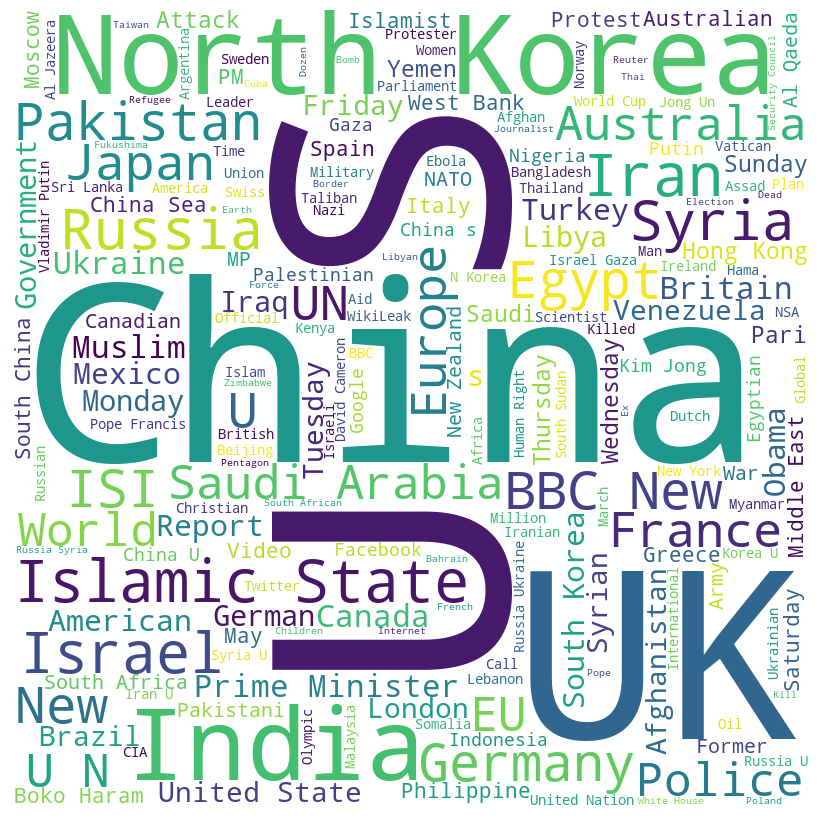

In [141]:
# Convert the DataFrame to a list of words
words_list = [row.word for row in dfWordTag.collect()]

# Generate the word cloud
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(' '.join(words_list))

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
# Show the plot
plt.show()


Additional Analysis

In [150]:
# Import necessary libraries
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from sparknlp.pretrained import PretrainedPipeline 
from pyspark.ml import PipelineModel

In [151]:
# Download the pre-trained BERT model and sentiment analysis model
bert_model = BertEmbeddings.pretrained()

small_bert_L2_768 download started this may take some time.
Approximate size to download 139.6 MB
[OK!]


In [ ]:
#to be checked
sentiment_model = PipelineModel.download("sentimentdl_use_imdb")

In [ ]:
# Define the Spark DataFrame with the text to analyze
text_df = dfAuthorTitle.selectExpr("title as text")

In [ ]:
# Create the Pipeline with the necessary stages
documentAssembler = DocumentAssembler().setInputCol("text").setOutputCol("document")
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
bertEmbeddings = BertEmbeddings().pretrained().setInputCols(["document", "token"]).setOutputCol("bert")
bertSentenceEmbeddings = BertSentenceEmbeddings().pretrained("sentimentdl_use_imdb").setInputCols(["document", "bert"]).setOutputCol("sentiment")
sentenceDetector = SentenceDetector().setInputCols(["document"]).setOutputCol("sentences")
sentimentDetector = SentimentDetector().setInputCols(["document", "sentences", "sentiment"]).setOutputCol("sentiment_score")



In [ ]:

# Assemble the pipeline
pipeline = Pipeline(stages=[documentAssembler, tokenizer, bertEmbeddings, bertSentenceEmbeddings, sentenceDetector, sentimentDetector])

# Fit the pipeline to the DataFrame and transform the DataFrame
result_df = pipeline.fit(text_df).transform(text_df)

# Show the resulting DataFrame
result_df.select("text", "sentiment_score.result").show(truncate=False)